In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor

path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s1_b12_u1.0"
path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:81
┌ Warning: assuming ED calculation for E_kin!! gm_wim and hubb.andpar need to be present
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:114
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2696, χLoc_ch(16:26) = 0.0932 
│ sum χupup check: 0.21822172722999147 ?≈? 0.25"
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:134


# Lambda charge solutions investigation

In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [4]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [5]:
sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
χsp_ω = kintegrate(kGrid, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
χsp_ω_2 = kintegrate(kGrid, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum_2 = real(sum_freq(χsp_ω_2[nlQ_sp2.usable_ω], [1], sh_2, mP2.β)[1])
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)

plot(nlQ_ch.usable_ω, real(χch_ω[nlQ_ch.usable_ω]),markershape = :hexagon,markersize = 2)
plot!(nlQ_ch.usable_ω, real(χch_ω_2[nlQ_ch.usable_ω]),markershape = :square,markersize = 2)

LoadError: UndefVarError: kintegrate not defined

In [6]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, νGrid, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill
│    as fill value outside usable ω range. =  as fill value outside usable ω range.
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:151
┌ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:28
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
│ χch sum = -0.2426590437282714, rhs = 0.6053832225745854
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:42
┌ Info: found 
│   χ_min = -0.09234595363898711
│   ". Looking for roots in intervall $(int)" = . Looking for roots in intervall [-0.09234595363898711, 1.8469190727797422]
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:143
┌ Info: Method 2 root:
│   r2 = Float64[]
└ @ 

(-0.09198279327815662, [0.0, 0.0], [-0.09234595363898711, 1.8469190727797422], [-Inf, Inf])

In [7]:
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

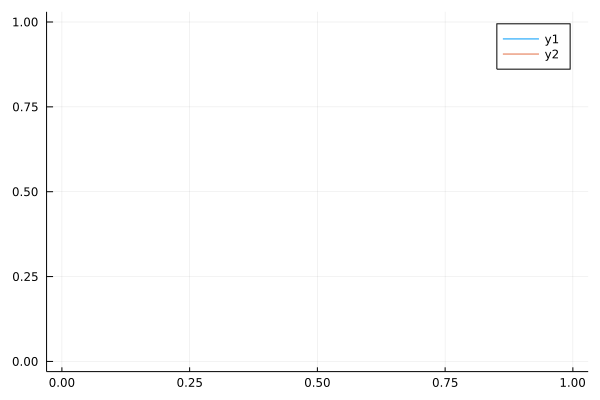

In [8]:
plot(real(Σ_ladder[1:end-30,end]))
plot!(real(Σ_ladder_corrected[1:end-30,end]))

In [9]:
plot(imag(Σ_ladder[1:30,end]))
#plot!(imag(Σ_ladder_corrected[1:30,end]))

LoadError: BoundsError: attempt to access 10×56 Matrix{ComplexF64} at index [1:30, 56]

In [10]:
sP.shift

true

In [11]:
sh_1 = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
χspw = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp.χ[nlQ_sp.usable_ω,:], dim=2)[:,1], [1], sh_1, mP.β)[1]

#plot(nlQ_sp.usable_ω, real(impQ_sp.χ_ω[impQ_sp.usable_ω]))
#plot!(nlQ_sp2.usable_ω, real(impQ_sp2.χ_ω[impQ_sp2.usable_ω]))

0.569657943547948 + 1.0277383251680811e-6im

In [12]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, νGrid, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill
│    as fill value outside usable ω range. =  as fill value outside usable ω range.
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:151
┌ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:28
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
│ χch sum = -0.2426590437282714, rhs = 0.6053832225745854
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:42
┌ Info: found 
│   χ_min = -0.000363160360837736
│   ". Looking for roots in intervall $(int)" = . Looking for roots in intervall [-0.000363160360837736, 0.00726320721675472]
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/lambdaCorrection.jl:143
┌ Info: Method 2 root:
│   r2 = [1.80131721

(-7.228491080441685e-15, [0.0, 0.0], [-0.000363160360837736, 0.00726320721675472], [-Inf, Inf])

nothing: old=0.022919337508626597, new=[0.022919337508626434]

richardson: old=0.010033740564731804, new=[0.010033740564730212]


In [13]:
using Roots

get_sum_helper = LadderDGA.get_sum_helper
kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β


sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
rhs1 = mP.n * (1 - mP.n/2) - χch_sum
rhs2 = real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
sh = get_sum_helper(usable_ω, sP, :b)
χupup_sum = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch.χ[usable_ω,:] .+ nlQ_sp.χ[usable_ω,:]), dim=2)[:,1], [1], sh, mP.β)[1]

println("usable range: $usable_ω\nχupup_nc=$χupup_sum")

χ_in = nlQ_sp.χ
usable_ω_i = nlQ_sp.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs1
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r2 = find_zeros(f, 0.02, 20.0, verbose=true)

println("lambda $r2")

LoadError: cannot assign a value to variable LadderDGA.get_sum_helper from module Main